In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

In [2]:
batch_size = 128
total_epoch = 30
learning_rate = 0.01
use_cuda = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()
print(use_cuda)

True


In [3]:
# dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training Function
def train(model,train_loader):
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = []
    for i, (image, label) in enumerate(train_loader):
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
        
        pred_label = model(image)
        loss = criterion(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [5]:
# Evaluation Fuction
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    
    total_cnt = 0
    correct_cnt = 0
    
    for i, (image, label) in enumerate(test_loader):
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        out = model(image)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += image.data.size()[0]
        correct_cnt += (pred_label == label.data).sum().item()
        
    return correct_cnt / total_cnt

In [6]:
# CIFAR10 MLP Model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 6272)
        self.fc2 = nn.Linear(6272, 4608)
        self.fc3 = nn.Linear(4608, 2048)
        self.fc4 = nn.Linear(2048, 256)
        self.fc5 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)
    
    def name(self):
        return "SimpleMLP"

In [7]:
# Training & Evaludation
mlp_model = SimpleMLP().cuda()
train_loss_lst = []
test_accuracy_lst = []
for epoch in range(total_epoch):
    train_loss = train(mlp_model, train_loader)
    train_loss_lst.append(train_loss)
    test_accuracy = eval(mlp_model, test_loader)
    test_accuracy_lst.append(test_accuracy)
    
    print("Epoch: [{}/{} ({:.2f}%)]\ttrain_loss: {}\ttest_accuracy: {}".
          format(epoch + 1, total_epoch, 
                 100 * ((epoch + 1) / total_epoch),
                 train_loss, test_accuracy))

summary(mlp_model, input_size = (3,32,32))

Epoch: [1/30 (3.33%)]	train_loss: 2.2925621957120383	test_accuracy: 0.166
Epoch: [2/30 (6.67%)]	train_loss: 2.2348927347861287	test_accuracy: 0.1929
Epoch: [3/30 (10.00%)]	train_loss: 2.0809603966105623	test_accuracy: 0.2622
Epoch: [4/30 (13.33%)]	train_loss: 1.993512384117107	test_accuracy: 0.2864
Epoch: [5/30 (16.67%)]	train_loss: 1.9222503998090543	test_accuracy: 0.3117
Epoch: [6/30 (20.00%)]	train_loss: 1.87206835515054	test_accuracy: 0.3234
Epoch: [7/30 (23.33%)]	train_loss: 1.8407213389111297	test_accuracy: 0.3446
Epoch: [8/30 (26.67%)]	train_loss: 1.8074708573348688	test_accuracy: 0.3429
Epoch: [9/30 (30.00%)]	train_loss: 1.7724926758300312	test_accuracy: 0.3603
Epoch: [10/30 (33.33%)]	train_loss: 1.7319655860476482	test_accuracy: 0.368
Epoch: [11/30 (36.67%)]	train_loss: 1.70385106201367	test_accuracy: 0.3975
Epoch: [12/30 (40.00%)]	train_loss: 1.6773675356984443	test_accuracy: 0.4035
Epoch: [13/30 (43.33%)]	train_loss: 1.647132964695201	test_accuracy: 0.3924
Epoch: [14/30 (46.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

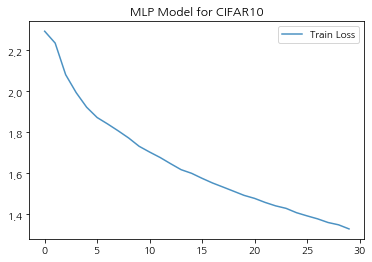

In [9]:
plt.clf()
plt.title("MLP Model for CIFAR10")
plt.plot(train_loss_lst, '-', label='Train Loss', alpha=0.8)
plt.legend(loc='best')
plt.show()

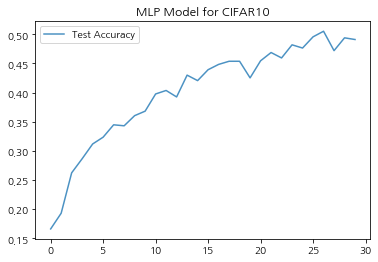

In [10]:
plt.clf()
plt.title("MLP Model for CIFAR10")
plt.plot(test_accuracy_lst, '-', label='Test Accuracy', alpha=0.8)
plt.legend(loc='best')
plt.show()